# Chaohu result plot


In [2]:
import os,yaml
import pandas as pd
import numpy as np
from swmm_api import read_inp_file
from envs.chaohu import chaohu
from utils.config import Arguments
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rc('font',family = 'Times New Roman')
colors = {'IQL':'#1f77b4','VDN':'#2ca02c', 'DQN':'#ff7f0e','HC':'#d62728'}

HERE = os.getcwd()

## Plot training rewards

In [32]:
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)['chaohu']
hyp_test = hyps['test']
cwd = os.path.join(HERE,hyp_test['cwd'])
agents = hyp_test['test_agents']
records = {'eval_perfs':{},'train_rewards':{}}
for agent in agents:
    model_dir = os.path.join(HERE,hyps[agent]['cwd'])
    if 'eval_perfs.npy' not in os.listdir(model_dir):
        model_dir = os.path.join(model_dir,'..')
    for item in records:
        records[item][agent] = np.load(os.path.join(model_dir,'%s.npy'%item))


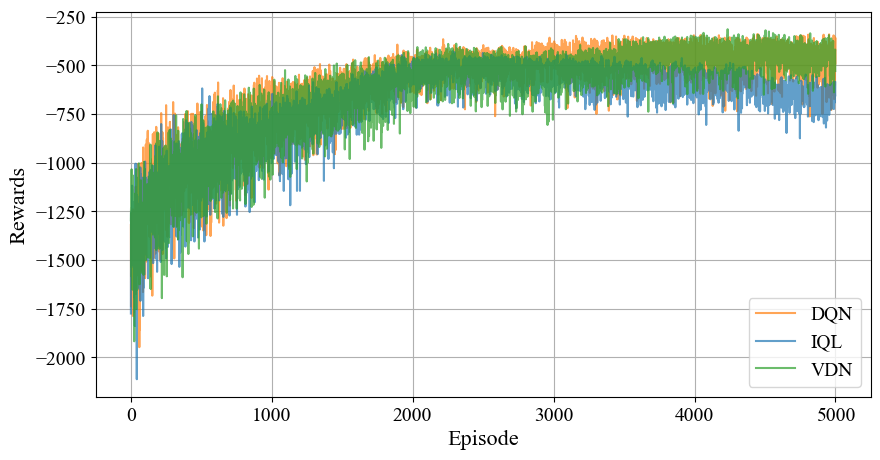

In [33]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (10,5))
lines = []
for agent,record in records['train_rewards'].items():
    rewards = ax.plot(np.arange(len(record)),record.sum(axis=1),color = colors[agent],label=agent,alpha=0.7)
    lines += rewards
    ax.set_xlabel('Episode',fontsize=16)
    ax.set_ylabel('Rewards',fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid(True)
ax.legend(lines,[f.get_label() for f in lines],loc='lower right',fontsize=14)
fig.savefig(os.path.join(cwd,'train_rewards.png'),dpi=600)

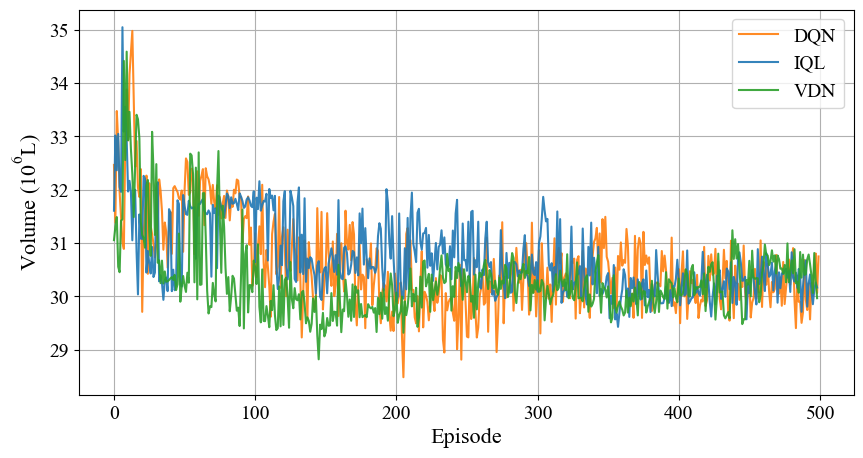

In [34]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (10,5))
lines = []
for agent,record in records['eval_perfs'].items():
    perfs = ax.plot(np.arange(len(record)),record.sum(axis=1)/2e3,color = colors[agent],label=agent,alpha=0.9)
    lines += perfs
    ax.set_xlabel('Episode',fontsize=16)
    ax.set_ylabel('Volume ($\mathregular{10^6 L}$)',fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid(True)
ax.legend(lines,[f.get_label() for f in lines],loc='upper right',fontsize=14)
fig.savefig(os.path.join(cwd,'eval_perfs.png'),dpi=600)

## Plot performance (CSO&flooding) result

In [53]:
env = chaohu()
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)[env.config['env_name']]
hyp_test = hyps['test']
args = Arguments(env.get_args(), hyp_test)
logger = args.init_test(load=True)

| Arguments Keep cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu
| Arguments Create cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu


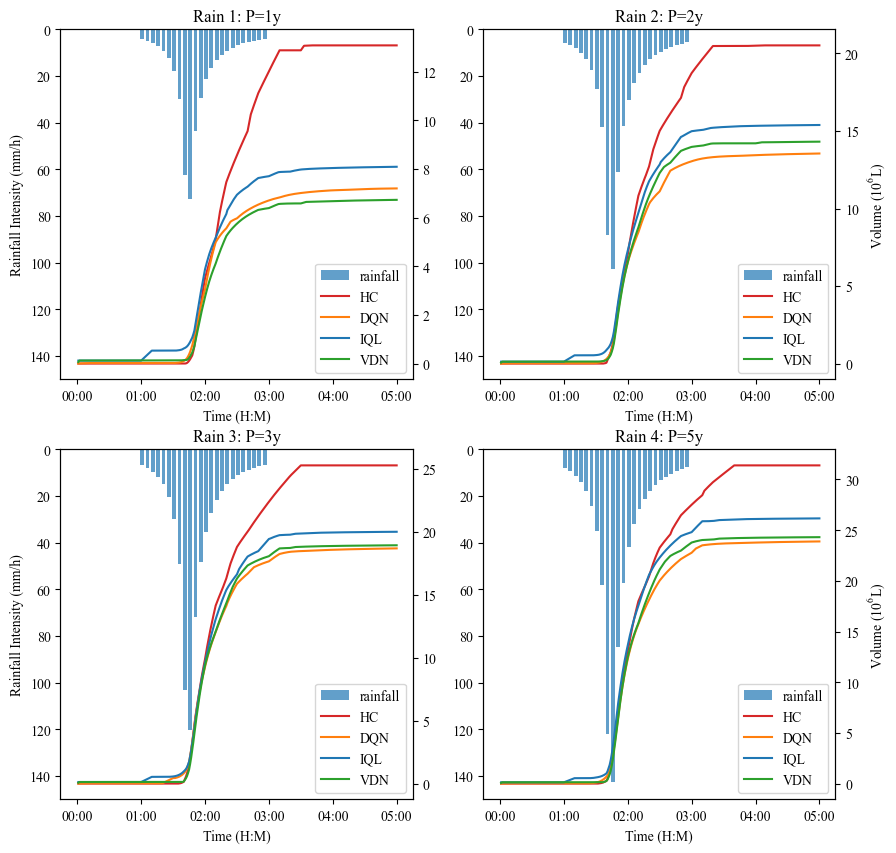

In [57]:

pump_class = ['CC-S','CC-R','JK-S','JK-R']
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

for i,(event,record) in enumerate(logger.records.items()):
    event = event.replace('_',' ')
    if 'P' in record:
        event += ': P='+record['P']
    targets = {k:pd.read_json(v)[:5*60] for k,v in record['target'].items()}
    ax = eval('ax%s'%(i+1))
    # Plot CSO & flooding
    # for col,ax in zip(['Flooding','CSO'],[axL,axR]):
    rain_index = [time for idx,time in enumerate(targets['HC'].index) if idx%5==0]
    rain = ax.bar(rain_index,targets['HC'].loc[rain_index,'Rainfall'],
    label='rainfall',width=0.0025,alpha=0.7,zorder=1)

    axR = ax.twinx()
    ax.invert_yaxis()
    ax.set_ylim(150,0)
    objs = [rain]
    for agent,table in targets.items():
        flood = axR.plot(table.index,table['Flooding']+table['CSO'],color=colors[agent],label=agent)
        objs += flood
    ax.set_xlabel('Time (H:M)')
    axR.set_title(event)
    axR.yaxis.set_ticks_position('right')
    axR.yaxis.set_label_position('right')    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axR.legend(objs,[l.get_label() for l in objs],loc='lower right')
    if i in [1,3]:
        axR.set_ylabel('Volume ($\mathregular{10^6 L}$)')
    if i in [0,2]:
        ax.set_ylabel('Rainfall Intensity (mm/h)')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=5,frameon=False)
fig.savefig(os.path.join(args.cwd,'total_perf'))


### Plot CSO & flooding separately

In [ ]:

pump_class = ['CC-S','CC-R','JK-S','JK-R']

for event,record in logger.records.items():
    targets = {k:pd.read_json(v)[:5*60] for k,v in record['target'].items()}

    # Plot CSO & flooding
    fig,(axL,axR) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
    for col,ax in zip(['Flooding','CSO'],[axL,axR]):
        rain_index = [time for idx,time in enumerate(targets['HC'].index) if idx%5==0]
        rain = ax.bar(rain_index,targets['HC'].loc[rain_index,'Rainfall'],
        label='rainfall',width=0.0025,alpha=0.7,zorder=1)

        ax2 = ax.twinx()
        ax.invert_yaxis()
        ax.set_ylim(150,0)
        objs = [rain]
        for agent,table in targets.items():
            flood = ax2.plot(table.index,table[col],color=colors[agent],label=agent)
            objs += flood
        ax.set_xlabel('Time (H:M)')
        ax2.set_title(col)
        ax2.yaxis.set_ticks_position('right')
        ax2.yaxis.set_label_position('right')    
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax2.legend(objs,[l.get_label() for l in objs],loc='lower right')
    ax2.set_ylabel('Volume ($\mathregular{10^6 L}$)')
    axL.set_ylabel('Rainfall Intensity (mm/h)')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=5,frameon=False)
    fig.savefig(os.path.join(args.cwd,'perf_%s'%event))
    print("Finish plot: perf_%s"%event)

## Summarize the control performance

In [51]:
# TODO: test performance summation
env = chaohu()
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)[env.config['env_name']]
hyp_test = hyps['test']
args = Arguments(env.get_args(), hyp_test)
logger = args.init_test(load=True)

| Arguments Keep cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu
| Arguments Create cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu


In [52]:
columns = []
for col in ['Flooding and CSO volume','Pumping energy']:
    columns += [(col,agent) for agent in ['HC']+hyp_test['test_agents']]
columns = pd.MultiIndex.from_tuples(columns)
results = pd.DataFrame(columns=columns)
for event,record in logger.records.items():
    perf = {(k,key):v for key,value in record['performance'].items() for k,v in value.items()}
    for agent in ['HC']+hyp_test['test_agents']:
        perf['Flooding and CSO volume',agent] = perf['System flooding',agent] + perf['CSO',agent]
    results.loc[event] = perf

logger.load(os.path.join(logger.cwd,'records100.json'))
perfs = {k:0 for k in results.columns}
for event,record in logger.records.items():
    perf = {(k,key):perf[k,key]+v for key,value in record['performance'].items() for k,v in value.items()}
for agent in ['HC']+hyp_test['test_agents']:
    perf['Flooding and CSO volume',agent] = perf['System flooding',agent] + perf['CSO',agent]
results.loc['Total of 100 rainfall events'] = perf
results.round(3).to_clipboard()
results

Flooding and CSO volume  ... Pumping energy
                                                  HC  ...            VDN
Rain_1                                        13.160  ...          65.85
Rain_2                                        20.549  ...          96.83
Rain_3                                        25.237  ...         114.07
Rain_4                                        31.490  ...         142.47
Total of 100 rainfall events                2345.241  ...        9732.98

[5 rows x 8 columns]

## Plot operation result

In [24]:
# TODO: design summation table
env = chaohu()
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)[env.config['env_name']]
hyp_test = hyps['test']
args = Arguments(env.get_args(), hyp_test)
logger = args.init_test(load=True)

| Arguments Keep cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu
| Arguments Create cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu


Finish plot: depth_setting_Rain 0
Finish plot: depth_setting_Rain 1
Finish plot: depth_setting_Rain 2
Finish plot: depth_setting_Rain 3
Finish plot: depth_setting_Rain 4


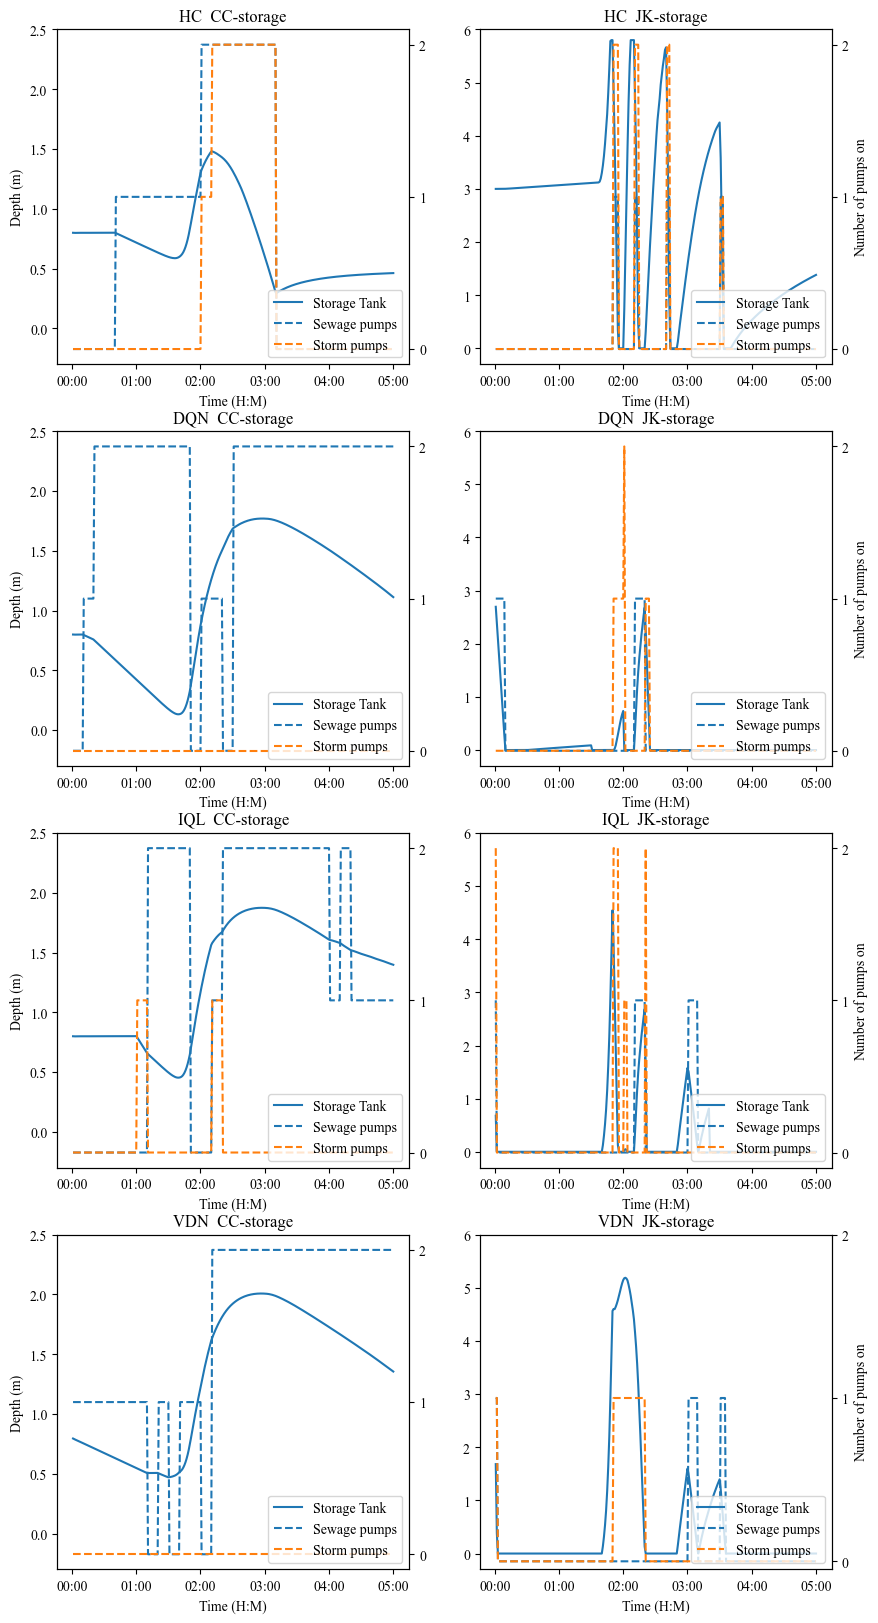

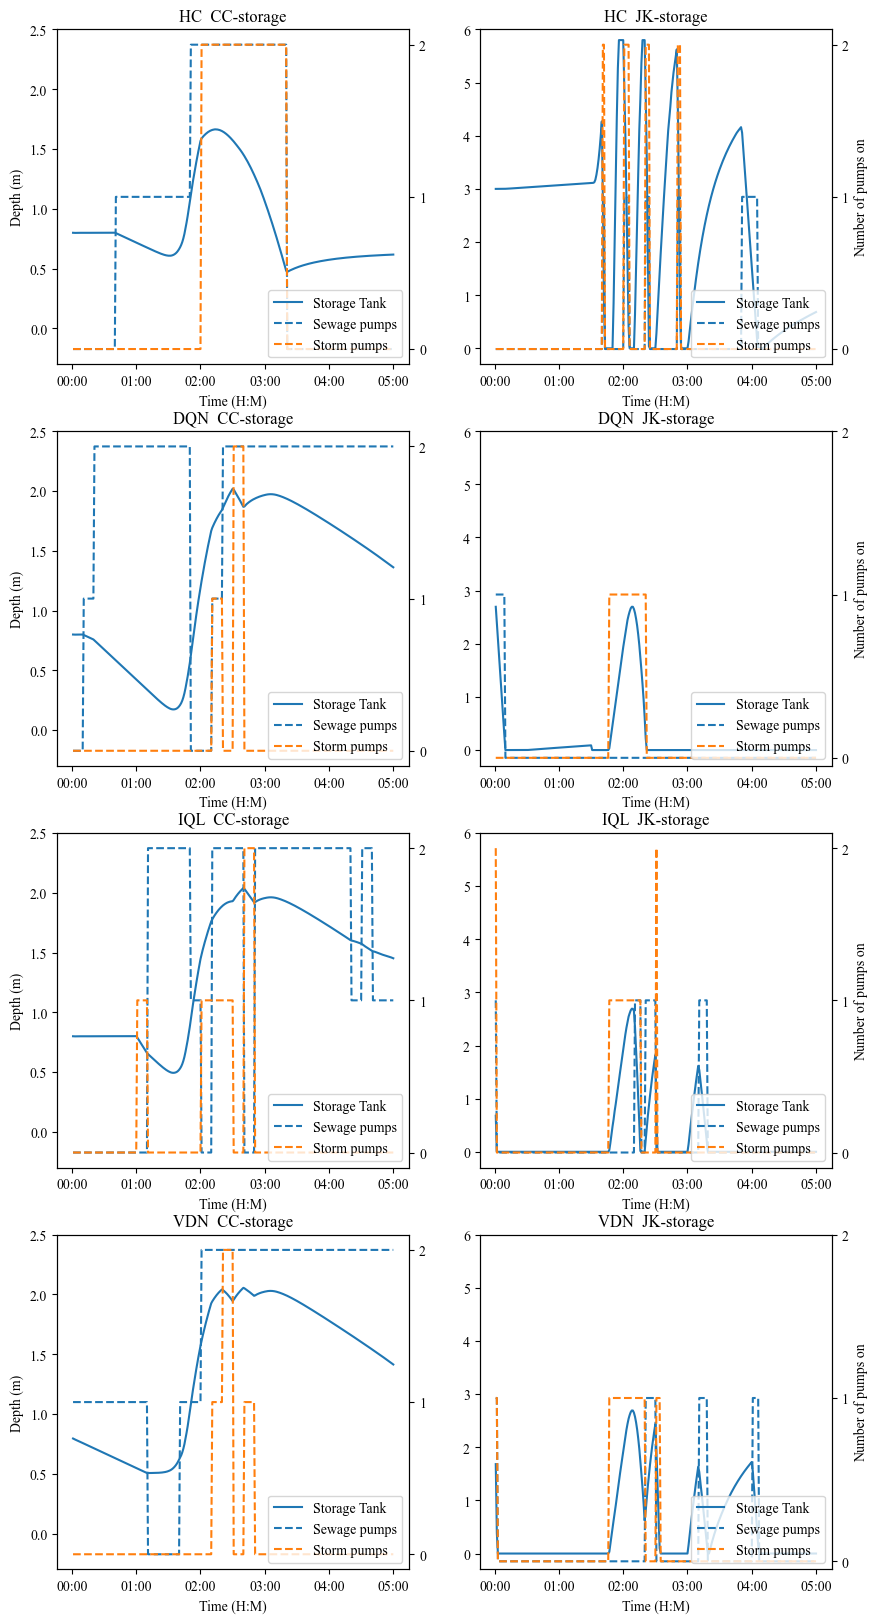

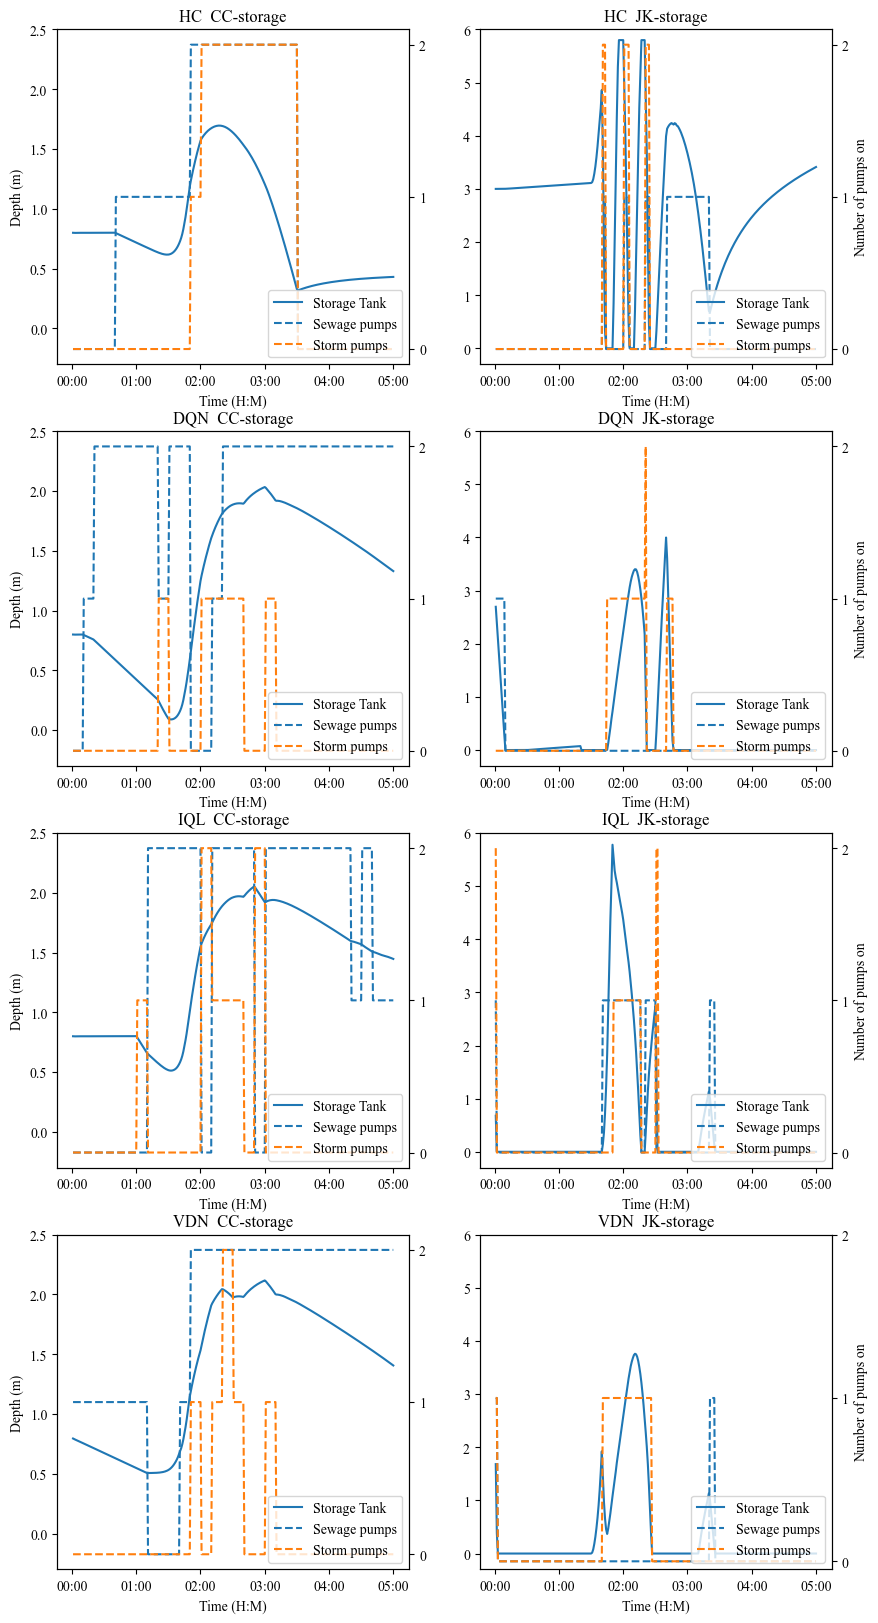

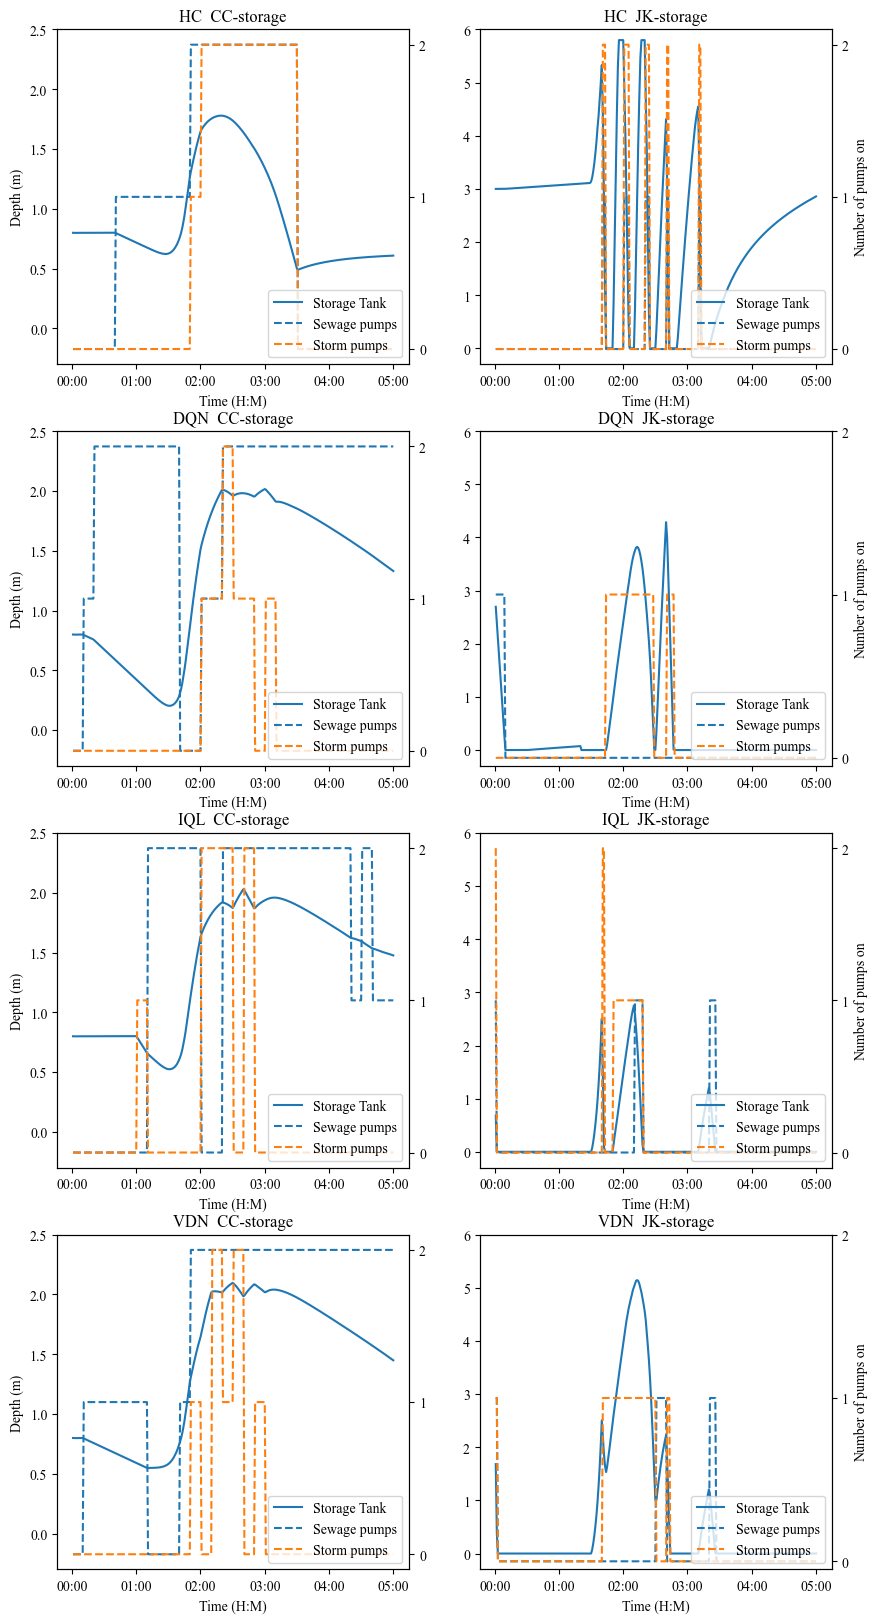

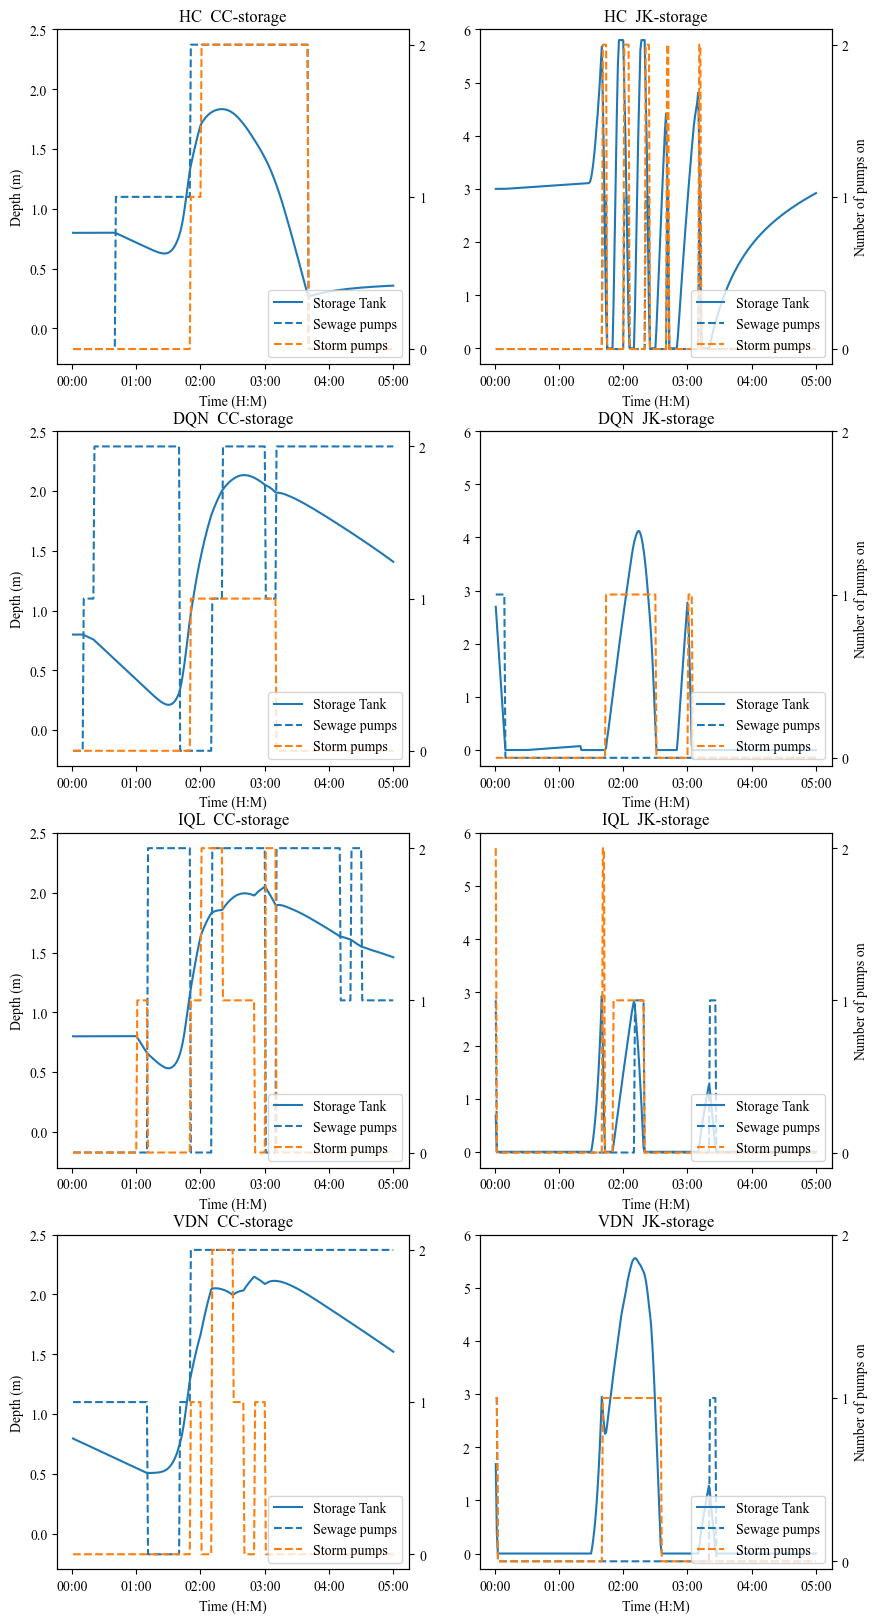

In [25]:
pump_class = ['CC-S','CC-R','JK-S','JK-R']
for event,record in logger.records.items():
    operats = {k:pd.read_json(v)[:5*60] for k,v in record['operation'].items()}
    # Plot the opertion details in CC & JK
    fig,axes = plt.subplots(nrows=len(operats),ncols=2,figsize=(10,5*(len(operats))))
    axes = np.array([axes]) if len(axes.shape) == 1 else axes
    for (agent,operat),(axL,axR) in zip(operats.items(),axes):

        for pump in pump_class:
            operat[pump] = operat.apply(lambda row:sum([row[col]
            for col in operat.columns if col.startswith(pump)]),axis=1).astype(int)
            operat[pump] = operat.apply(lambda row: 0 if row[pump[:3]+'storage']==0 else row[pump],axis=1)
        operat = operat[args.storage + pump_class]

        # rain = axL.bar(operat.index,operat['rainfall'],label='rainfall',width=0.003,alpha=0.6,zorder=1)
        # axL.set_ylabel('Rainfall Intensity (mm/h)')
        for col,ax in zip(['CC','JK'],[axL,axR]):
            depth = ax.plot(operat.index,operat[col+'-storage'],label='Storage Tank')
            ax2 = ax.twinx()
            ns = ax2.plot(operat.index,operat[col+'-S'],'--',label='Sewage pumps')
            nr = ax2.plot(operat.index,operat[col+'-R'],'--',label='Storm pumps')
            objs = depth+ns+nr
            ax.set_xlabel('Time (H:M)')
            ax2.legend(objs,[l.get_label() for l in objs],loc='lower right')
            ax2.set_title(agent + '  '+ col+'-storage')
            ax2.set_yticks([0,1,2])
            ax2.yaxis.set_ticks_position('right')
            ax2.yaxis.set_label_position('right')    
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            ax.set_ylim(-0.3,env.node_properties[col+'-storage']['fullDepth']+0.2)
            
        ax2.set_ylabel('Number of pumps on')
        axL.set_ylabel('Depth (m)')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=3,frameon=False)
    fig.savefig(os.path.join(args.cwd,'depth_setting_%s'%event))
    print("Finish plot: depth_setting_%s"%event)